## Download the data


In [57]:
"""
This cell is used for downloading the data from Internet
"""

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml/blob/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz?raw=true"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if not os.path.exists(tgz_path):
        urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [58]:
## test some os function
print(os.path.join(HOUSING_PATH,""))

datasets/housing/


## onload the data and feels it

In [59]:
"""
defing the funtion for
onload the data from csv to pandas.
"""
import pandas as pd 
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)


In [60]:
## see some small piece of data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [61]:
## this is the basic statictics
"""NOTICED: 20433 of total-bedrooms, means there is some missing value"""
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [62]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [63]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1179600b8>,
      dtype=object)

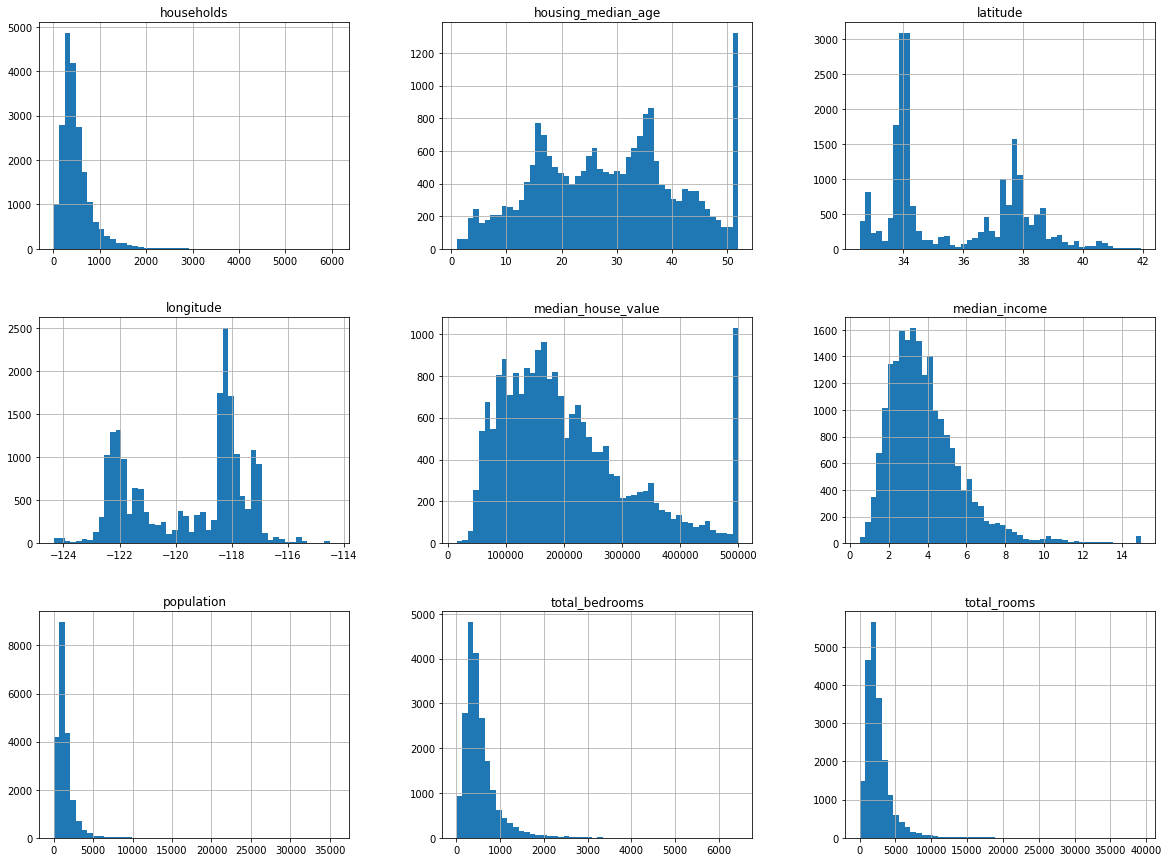

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(figsize=(20,15),bins=50)

## Cut a test set
There are two main considerations to cut the test set.
1. random
2. stratify sample

random way

In [65]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(test_ratio* len(data))
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), " train +", len(test_set), " test")

16512  train + 4128  test


## Problem on this train_test selection
The above method is not stable. **Not stable** means that, every time you run this function, it will give you a diffeent shuffled_indices. 
In that case, it means every time our train set is different. 

The disadvantage is that, as time goes by, the model we trained will see the **whole data set** and the test result is meaningless. 

Solution: **1.Use hash function** to maintain the stable train and test set.

In [66]:
import hashlib


def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1]< 256 * test_ratio

def split_train_test_by_idhash(data, test_ratio, id_col, hash=hashlib.md5):
    ids = data[id_col]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]
    
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_idhash(housing_with_id, 0.2,"index")
print(len(train_set), " train +", len(test_set), " test")

16362  train + 4278  test


## Visualize the data

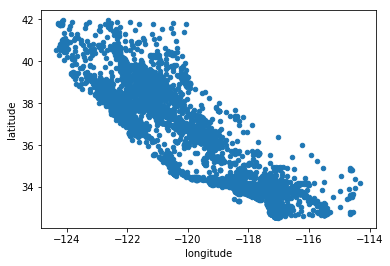

In [67]:
housing.plot(kind="scatter",x="longitude",y="latitude")

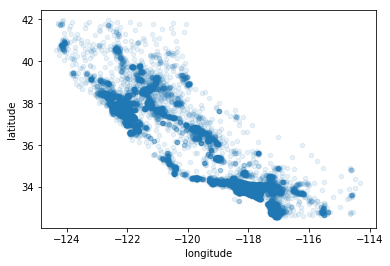

In [68]:
# the picture above is not very clear
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)

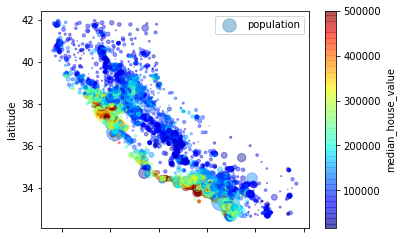

In [69]:
housing.plot(kind="scatter", x= "longitude", y= "latitude", alpha=0.4, s= housing["population"]/100, label="population",
            c="median_house_value", cmap = plt.get_cmap("jet"),colorbar=True)
plt.legend()

The above picture look much better.
Several importnat elements for scatter: **size, color, alpha**

## Find the Corrleation

In [70]:
corr_matrix = housing.corr()

In [71]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Try Arrtibute Combinations

In [72]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

In [73]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
population            -0.024650
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

# Data Preparation

## remove the label from the train set

In [74]:
housing = train_set.drop("median_house_value", axis = 1)
housing_labels = train_set["median_house_value"].copy()

## Data cleaning

### handling the missing data or similar
* del the corresponding row
* del the whole attributes
* set the missing value to something, mean, max, min, median

In [75]:
#1
housing.dropna(subset=["total_bedrooms"])

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,NEAR BAY
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,NEAR BAY
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,NEAR BAY
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,NEAR BAY
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,NEAR BAY


In [76]:
#2
housing.drop("total_bedrooms",axis=1)

,index,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,1094.0,514.0,3.6591,NEAR BAY
7,7,-122.25,37.84,52.0,3104.0,1157.0,647.0,3.1200,NEAR BAY
8,8,-122.26,37.84,42.0,2555.0,1206.0,595.0,2.0804,NEAR BAY
9,9,-122.25,37.84,52.0,3549.0,1551.0,714.0,3.6912,NEAR BAY
10,10,-122.26,37.85,52.0,2202.0,910.0,402.0,3.2031,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,1098.0,468.0,3.0750,NEAR BAY


### there is much more work to do in this stage for option3

In [77]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = "median")

In [78]:
housing_num = housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [79]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## handle text and Categorial attributes

In [80]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([3, 3, 3, ..., 1, 1, 1])

In [81]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [82]:
## why not combine the above two setp into one shot
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16362x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16362 stored elements in Compressed Sparse Row format>

## Previsouly the Label encoder is not appropriate.


In [83]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [84]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16362x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16362 stored elements in Compressed Sparse Row format>

## how to write a customized Transformer

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(False)
housing_extra_attributes = attr_adder.transform(housing.values)
housing_extra_attributes

array([[0, -122.23, 37.88, ..., 'NEAR BAY', 0.12732919254658384,
        0.40062111801242234],
       [1, -122.22, 37.86, ..., 'NEAR BAY', 0.008746355685131196,
        0.4606413994169096],
       [2, -122.24, 37.85, ..., 'NEAR BAY', 0.10483870967741936,
        0.38306451612903225],
       ...,
       [20636, -121.21, 39.49, ..., 'INLAND', 0.05056179775280899,
        0.42134831460674155],
       [20638, -121.32, 39.43, ..., 'INLAND', 0.024291497975708502,
        0.5519568151147098],
       [20639, -121.24, 39.37, ..., 'INLAND', 0.011535688536409516,
        0.4441240086517664]], dtype=object)

## Feature Scaling 
* Min-Max  -> [0,1] -> will be sequeeze by outliers
* Standardize -> unit-gaussian -> not affected by outliers

## Transformation Pipelines

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
                [
                    ('imputer', Imputer(strategy="median")),
                    ('attribs_adder', CombinedAttributesAdder()),
                    ('std_scaler', StandardScaler())
                ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr.shape

(16362, 12)

In [87]:
from sklearn.pipeline import FeatureUnion

num_attri_name = list(housing_num)
cat_attri_name = ["ocean_proximityz"]

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

## actually we only need to implement fit and transform.
## but we had better to follow the convention and inherit the TransformerMixin.
class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [95]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [96]:

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [97]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
print(housing_prepared.shape)

(16362, 17)


## After a whole lot of effort, we come to the model part

In [98]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [99]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [401373.42717849 418914.87573642 372061.20977645 316084.48251373
 256105.34906368]


In [100]:
print("Labels:", list(some_labels))

Labels: [452600.0, 358500.0, 352100.0, 341300.0, 299200.0]


## Measure the Error

In [101]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68470.74467407452

In [103]:
from sklearn.metrics import mean_absolute_error
lin_mse = mean_absolute_error(housing_labels, housing_predictions)
lin_mse

49590.52284851071

In [104]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [105]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## need to cut the training set to do CV

In [108]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [109]:

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [133941.48649597  78132.07667717  89453.73457494  76484.96112643
  99524.30786225  80182.56588982  71586.2676169  112876.97001644
  94500.17748688 128504.28548953]
Mean: 96518.68332363345
Standard deviation: 20933.39806874899


In [110]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [90053.63799942 62097.18928434 90835.14648817 62000.31249861
 82329.85979522 69854.28405385 54710.11463797 90217.76931174
 76969.4509176  57273.96142154]
Mean: 73634.17264084499
Standard deviation: 13548.947581694336


## try random forest

In [114]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [115]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21629.854427898557

In [116]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [99810.88712242 58836.1784198  72003.42397263 58297.1674701
 73164.32720784 61704.68361453 48465.81312524 82564.89646921
 73458.61283697 99003.08790026]
Mean: 72730.90781390113
Standard deviation: 16227.370409330484


In [117]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     73634.172641
std      14281.844752
min      54710.114638
25%      62024.531695
50%      73411.867486
75%      88122.693448
max      90835.146488
dtype: float64

In [118]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111652.42304475328